ライブラリのimport

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.initializers import he_normal
import keras.backend as K
import sqlalchemy as sa
import pandas as pd
import data.constant as con
from tqdm import tqdm
import component.create_raceID as cr
import classes.db_operation_class as db
import classes.convert_df as convert
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import component.create_raceID as cr
from tqdm import tqdm
import pickle
import IPython.core.display as display
import IPython.display
from sklearn.linear_model import LinearRegression
# 評価指標：決定係数
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import numpy as np


In [2]:
# インスタンスの作成
db_instans = db.Main()
convert_instans = convert.Main()
raceIdList = cr.get_save_race_id()

df = convert_instans.sql("""
                        SELECT *
                        FROM result_horse
                        LEFT JOIN race ON result_horse.race_id = race.race_id
                        LEFT JOIN prize_money ON race.race_id = prize_money.race_id
                        WHERE prize_money.ranking = 1;
                        """)

print(df)

             RACE_ID  RANKING  HORSEFRAME  HORSENUMBER      HNAME    HORSE_ID  \
0       201401010101        1           4            5  マコトグナイゼナウ  2012104840   
1       201401010101        2           8           14  ディープフォルツァ  2012104292   
2       201401010101        3           6            9    ウインアキレア  2012100229   
3       201401010101        4           3            4    サトノアッシュ  2012101359   
4       201401010101        5           4            6    ブラックバード  2012101504   
...              ...      ...         ...          ...        ...         ...   
435575  202210010503        9           7           11      ベルポート  2016105215   
435576  202210010503       10           6            9  タイセイロワイヤル  2018101490   
435577  202210010503       11           7           10    テーオールソー  2018100071   
435578  202210010503       12           8           13       ストレガ  2017101475   
435579  202210010503       13           2            2      クリオズナ  2018105247   

       GENDER AGE  WEIGHT J

In [3]:
# 走破タイム予測用カラム
columns = ["RUN_TIME","DISTANCE","WEIGHT","HORSE_TOTAL","PRIZE","HORSE_WEIGHT","WEIGHT_GAIN_LOSS","GENDER","GRADE","PLACE","WEATHER","GROUND","SPIN","SITUATION"]
runtimeDf = df[columns]
# runtimeDf["SPIN"].unique()

In [4]:
runtimeDf = pd.get_dummies(runtimeDf) # one-hot-encofing
runtimeDf = runtimeDf * 1              # true flaseを1 0に変換
runtimeDf = runtimeDf[runtimeDf["RUN_TIME"] > 0] #走破タイムが0以下の行を削除
runtimeDf

,RUN_TIME,DISTANCE,WEIGHT,HORSE_TOTAL,PRIZE,HORSE_WEIGHT,WEIGHT_GAIN_LOSS,GENDER_セ,GENDER_牝,GENDER_牡,...,GROUND_芝,GROUND_障害,SPIN_右,SPIN_左,SPIN_直,SPIN_障害,SITUATION_不良,SITUATION_稍重,SITUATION_良,SITUATION_重
0,89.9,1500,54.0,14,500,430,-2,0,0,1,...,1,0,1,0,0,0,0,0,1,0
1,89.9,1500,54.0,14,500,422,-4,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2,90.1,1500,54.0,14,500,444,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
3,90.3,1500,54.0,14,500,454,2,0,0,1,...,1,0,1,0,0,0,0,0,1,0
4,90.3,1500,51.0,14,500,454,4,0,0,1,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435575,60.5,1000,52.0,13,770,460,-14,0,1,0,...,0,0,1,0,0,0,0,0,1,0
435576,60.6,1000,56.0,13,770,498,-4,0,0,1,...,0,0,1,0,0,0,0,0,1,0
435577,60.7,1000,54.0,13,770,508,-12,0,0,1,...,0,0,1,0,0,0,0,0,1,0
435578,60.8,1000,55.0,13,770,456,-2,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [5]:
#説明変数と目的変数に分割
x = runtimeDf.iloc[:, 1:] #x説明変数
y = runtimeDf.iloc[:, 0]  #y目的変数
x.columns

Index(['DISTANCE', 'WEIGHT', 'HORSE_TOTAL', 'PRIZE', 'HORSE_WEIGHT',
       'WEIGHT_GAIN_LOSS', 'GENDER_セ', 'GENDER_牝', 'GENDER_牡', 'GRADE_オープン',
       'GRADE_新馬', 'GRADE_未勝利', 'GRADE_１勝クラス', 'GRADE_２勝クラス', 'GRADE_３勝クラス',
       'PLACE_中京', 'PLACE_中山', 'PLACE_京都', 'PLACE_函館', 'PLACE_小倉', 'PLACE_新潟',
       'PLACE_札幌', 'PLACE_東京', 'PLACE_福島', 'PLACE_阪神', 'WEATHER_小雨',
       'WEATHER_小雪', 'WEATHER_晴', 'WEATHER_曇', 'WEATHER_雨', 'WEATHER_雪',
       'GROUND_ダート', 'GROUND_芝', 'GROUND_障害', 'SPIN_右', 'SPIN_左', 'SPIN_直',
       'SPIN_障害', 'SITUATION_不良', 'SITUATION_稍重', 'SITUATION_良',
       'SITUATION_重'],
      dtype='object')

In [18]:
# 確認用
print(x)

        DISTANCE  WEIGHT  HORSE_TOTAL  PRIZE  HORSE_WEIGHT  WEIGHT_GAIN_LOSS  \
0           1500    54.0           14    500           430                -2   
1           1500    54.0           14    500           422                -4   
2           1500    54.0           14    500           444                 0   
3           1500    54.0           14    500           454                 2   
4           1500    51.0           14    500           454                 4   
...          ...     ...          ...    ...           ...               ...   
197570      1200    53.0           18    500           422               -16   
197571      1200    56.0           18    500           486               -10   
197572      1200    52.0           18    500           410               -12   
197573      1200    54.0           18    500           410                -2   
197574      1200    56.0           18    500           434                12   

        GENDER_セ  GENDER_牝  GENDER_牡  G

In [6]:
# スケーリング
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
# x_scaled
dataframe_x = pd.DataFrame(x_scaled)

dataframe_x

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-0.354912,-0.568553,-0.396129,-0.397822,-1.349298,-0.362589,-0.197976,-0.795090,0.859787,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
1,-0.354912,-0.568553,-0.396129,-0.397822,-1.614420,-0.675393,-0.197976,-0.795090,0.859787,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
2,-0.354912,-0.568553,-0.396129,-0.397822,-0.885335,-0.049785,-0.197976,1.257719,-1.163078,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
3,-0.354912,-0.568553,-0.396129,-0.397822,-0.553933,0.263019,-0.197976,-0.795090,0.859787,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
4,-0.354912,-2.258214,-0.396129,-0.397822,-0.553933,0.575823,-0.197976,-0.795090,0.859787,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196038,-1.071577,-1.131773,1.370690,-0.397822,-1.614420,-2.552216,-0.197976,1.257719,-1.163078,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
196039,-1.071577,0.557888,1.370690,-0.397822,0.506554,-1.613805,-0.197976,-0.795090,0.859787,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
196040,-1.071577,-1.694994,1.370690,-0.397822,-2.012102,-1.926608,-0.197976,1.257719,-1.163078,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036
196041,-1.071577,-0.568553,1.370690,-0.397822,-2.012102,-0.362589,-0.197976,1.257719,-1.163078,-0.293949,...,1.043097,-0.176336,0.758586,-0.696593,-0.092017,-0.176336,-0.194542,-0.442031,0.638615,-0.314036


In [6]:
#学習用データとテストデータに分割
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [7]:
#scikit-learnの重回帰分析
rl_model = LinearRegression()
# 学習
rl_model.fit(x_train,y_train)
# 予測
y_pred_test = rl_model.predict(x_test)

In [8]:
# 決定係数
r2_test = r2_score(y_test, y_pred_test)
# テスト結果の表示
print("R2スコア（テストデータ）:", r2_test)


R2スコア（テストデータ）: 0.9951082724942228


In [11]:
# モデルの保存
with open("./data/RUN_TIME_PREDICT.model", mode="wb") as f:
  pickle.dump(rl_model,f,protocol=2)

In [13]:
# 性能
print('決定係数（r2）:{}'.format(round(r2_score(y_test, y_pred_test),3)))
print('平均誤差（MAE）:{}'.format(round(mean_absolute_error(y_test, y_pred_test),3)))
print('RMSE:{}'.format(round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3)))

決定係数（r2）:0.995
平均誤差（MAE）:1.464
RMSE:2.023


In [17]:
len(y_test)

129624

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


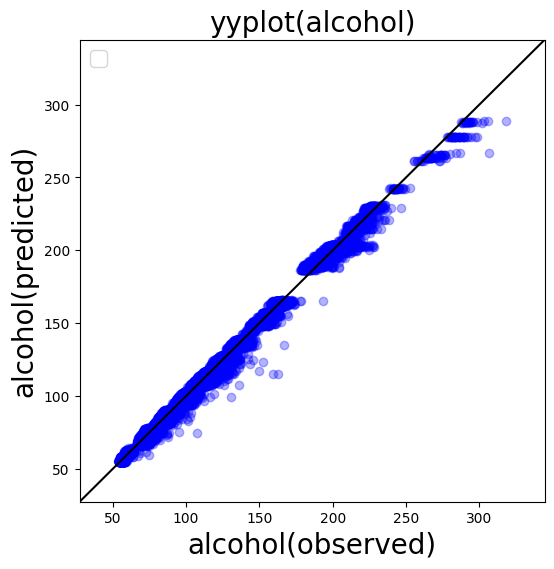

In [18]:
#予測実測プロットの作成
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test,color='blue',alpha=0.3)
y_max_ = max(y_test.max(), y_pred_test.max())
y_min_ = min(y_test.min(), y_pred_test.min())
y_max = y_max_ + (y_max_ - y_min_) * 0.1
y_min = y_min_ - (y_max_ - y_min_) * 0.1

plt.plot([y_min , y_max],[y_min, y_max], 'k-')

plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.xlabel('alcohol(observed)',fontsize=20)
plt.ylabel('alcohol(predicted)',fontsize=20)
plt.legend(loc='best',fontsize=15)
plt.title('yyplot(alcohol)',fontsize=20)
plt.savefig('yyplot.png')
plt.show()